In [88]:
import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *
from datetime import *

import keras
from keras.applications import *
import lightgbm as lgbm
import os
from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Lambda, Layer,Flatten, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dense

import shutil
import collections
from collections import *
from keras import optimizers
import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from sklearn.utils import class_weight
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from os.path import isfile, join
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from skimage import morphology

from skimage import filters
import matplotlib.pyplot as plt
from scipy import ndimage as ndi



## The Kaufland Case – Recognize the Product

https://www.datasciencesociety.net/datathon/2018/01/30/the-kaufland-case-recognize-the-product/



# Abstract

This paper presents a machine learning based approach for solving the business problem of identifying from pictures the products chosen by the Kaufland customers. These pictures are all taken from the same angle and typically show one or multiple products from the same category in a bag which makes the background and the bag recurrent elements. 

Here we explored the method of transfer learning - using already trained and very deep NN like InceptionV3, InceptionResnetV2, VGG19, Resnet50 with combinations of retraining and no retraining of the existing layers. We solved this  multiclassification problem of predicting the probabilities of each class of products by adding different final custom layers and we obtain the best result of 97.37% accuracy on a validation set of 20% (which was never seen by the training model) using the top 3 metric.

This result was achieved with the model VGG19 which distinguished itself not only for providing the best categorical accuracy but also for training speed, execution speed once deployed and reduced resource consumption.

# 3. Data Preparation

This section provides an overview of the loading, preprocessing and exploring the input data process.

## 3.1 Data Loading


The first phase consists in loading the data provided in the input archive.  
__We will select and use all input data which has been provided__.

The parent folder 'Data_Datathon_Kaufland' contains 68 subfolders, each corresponding visibly to a category of vegetables.

The name of these categories corresponds to a 4 digit identifier followed by the german translation of the type of product.

In [5]:
basedir = 'data/Data_Datathon_Kaufland'
print('Content of input folder: ', listdir(basedir))
print('Number of input subfolders ', len (listdir(basedir)))

Content of input folder:  ['1073_Kuerbis Hokkaido', '_5233_Spitzkohl', '_7777_Wassermelone gelb', '_5032_Landgurken', '9118_Spitzpaprika', '3917_Pfirsiche', '_9275_Zwiebeln weiss', '_3959_Pflaumen', '6911_aepfel', '1044_Kochbananen', '9055_Birnen Abate Fetel', '3942_Paprika orange', '_6294_Champignon Riesen', '_5277_Kopfkohl', '_7389_Meerrettich', '_7347_Auberginen Graff', '_6322_Buschbohnen', '_5074_Chinakohl', '_3992_Zwetschgen', '4671_Kartoffeln rotsch', '_7276_Filderkohl', '_6210_Wirsing', '3855_Kirschen', '3247_Zwiebeln', '6967_Kartoffeln fk', '_7762_Zwiebeln rot', '6297_Zucchini gelb', '_6115_Rotkohl', '_9729_Kraeuterseitlinge', '_3927_Paprika gruen', '_3790_Trauben kernlos', '_6696_Einlegegurken', '_5885_Wassermelone', '9045_aepfel Pink Lady', '6667_Pflaumen gelb', '5949_Moehren', '9015_Mandarinen', '3820_Paprika gelb', '_6178_Weisskohl', '_6534_Knoblauch', '_5160_Rote Bete', '7025_Kuerbisspezialitaet', '3824_Aprikosen', '_6389_Champignon braun', '_6445_Champignon weiss', '7240_

The following step consists in creating placeholders for the image files and their categories. 

We will create 2 arrays, one keeping the category name and the second one - the path from where we can load each photo.

In [7]:
cat = [] # categories
photo_path = [] # image path relative to basedir
for d in listdir(basedir):
    for img in listdir(basedir + '/' + d):
        cat.append(d)
        photo_path.append(basedir + '/' + d + '/' + img)


For facility of use let's combine the 2 arrays defined above into a single dataframe df :

In [12]:
df = pd.DataFrame()
df['path'] = pd.Series(filepath)
df['cat']= pd.Series(cat)
df.head()
del cat, photo_path

path                    cat
0  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido
1  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido
2  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido
3  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido
4  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido

### Preload all images and verify data quality

In order to speed up training time we load in memory all images.   
This avoids repetitively spending time on I/O operations during the training and evaluation phases.

The very first time the code below is executed all images are loaded in 'images' vector in the order they were indexed in the dataframe.    


We take advantage of this iteration in order to confirm that the hypothesis in the case description stating that all images have the same size of namely 480 and 640 pixels is correct.

In [16]:
img_width, img_height = 480, 640

# preload images into images vector
if os.path.isfile('data/images.npy'):
    images = np.load('data/images.npy')
else:
    images = []
    for path in tqdm(df.path.values):
        img = misc.imread(path)
        if img.shape != (img_width, img_height):
            print('Image %s has invalid shape %s ' % (path, img.shape))
        images.append(img)
    np.save('data/images.npy', images)

At this point we confirmed that all images have the expected size and they are loaded in memory in 'images' array.

## 3.2 Construct required data phase

### Categories label encoding

Product categories are the target variable in our Kaufland case.  
The standard way of handling categorical variables is to label encode them and/or maintain a one hot encoded version.

In a first phase we label encode all categories, process which will map each category to a different numeric value.

The one hot encoding phase will be implemented and explained later on, during the training, but it will be applied on the label encoding values obtaine below:

In [22]:
le = preprocessing.LabelEncoder()
le.fit(df.cat.unique())

df['y'] = le.transform(df.cat) 
df.head()

LabelEncoder()

path                    cat  \
0  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
1  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
2  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
3  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
4  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   

             german  y  
0  Kuerbis Hokkaido  1  
1  Kuerbis Hokkaido  1  
2  Kuerbis Hokkaido  1  
3  Kuerbis Hokkaido  1  
4  Kuerbis Hokkaido  1

The label encoding process created 68 distinct integer values from 0 to 67.

In [24]:
print('Unique label encoding values ', sorted(df['y'].unique()))

Unique label encoding values  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


In order to implement the inverse process of mapping the label encoded variable to the original value, we can use the inverse_transform method:

In [28]:
category_number = 1
print(le.inverse_transform([category_number]))

['1073_Kuerbis Hokkaido']


For reference purposes, Keras offers the method to_categorical which allows for the quick conversion between label encoded and one hote encoded values.

In [73]:
to_categorical(df['y'].values).shape

(37795, 68)

In [75]:
# reverse conversion (one hot -> category label)
y_train = to_categorical(df['y'].values)
def y_test_to_labels(y_test):
    inverted = np.apply_along_axis(np.argmax, 1, y_test)
    return le.inverse_transform(inverted)
y_test_to_labels(y_train[:2])

array(['1073_Kuerbis Hokkaido', '1073_Kuerbis Hokkaido'], dtype=object)

## 3.3 Exploratory data analysis

As shown below, the input contains 37795 images representing 37795 distinct categories :

In [9]:
print('The input contains %s images representative of %s distinct categories' % (len(photo_path), len(cat)))


The input contains 37795 images representative of 37795 distinct categories


### Categories exploration

In order enrich the meaningfulness of the data analysis from a business point of view, we isolate the word label for each category:

In [19]:
df['german'] = df.cat.apply(lambda x: x[5:] if x[0] != '_' else x[6:])
print('Unique german names' , df['german'].unique())
df.head()

Unique german names ['Kuerbis Hokkaido' 'Spitzkohl' 'Wassermelone gelb' 'Landgurken'
 'Spitzpaprika' 'Pfirsiche' 'Zwiebeln weiss' 'Pflaumen' 'aepfel'
 'Kochbananen' 'Birnen Abate Fetel' 'Paprika orange' 'Champignon Riesen'
 'Kopfkohl' 'Meerrettich' 'Auberginen Graff' 'Buschbohnen' 'Chinakohl'
 'Zwetschgen' 'Kartoffeln rotsch' 'Filderkohl' 'Wirsing' 'Kirschen'
 'Zwiebeln' 'Kartoffeln fk' 'Zwiebeln rot' 'Zucchini gelb' 'Rotkohl'
 'Kraeuterseitlinge' 'Paprika gruen' 'Trauben kernlos' 'Einlegegurken'
 'Wassermelone' 'aepfel Pink Lady' 'Pflaumen gelb' 'Moehren' 'Mandarinen'
 'Paprika gelb' 'Weisskohl' 'Knoblauch' 'Rote Bete' 'Kuerbisspezialitaet'
 'Aprikosen' 'Champignon braun' 'Champignon weiss' 'Tomaten, Fleisch'
 'Plattpfirsiche' 'Orangen' 'Birnen' 'Ingwer' 'Tomaten, Rispen'
 'Suesskartoffeln' 'Erdnuesse Giants' 'Walnuesse' 'Fenchel'
 'Kuerbis Butternut' 'Haselnuesse Jumbo' 'Auberginen' 'Trauben blau'
 'Sellerie' 'Erdbeeren' 'Bananen' 'Zucchini' 'Trauben hell' 'Paprika rot'
 'Nektarinen'

path                    cat  \
0  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
1  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
2  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
3  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   
4  data/Data_Datathon_Kaufland/1073_Kuerbis Hokka...  1073_Kuerbis Hokkaido   

             german  
0  Kuerbis Hokkaido  
1  Kuerbis Hokkaido  
2  Kuerbis Hokkaido  
3  Kuerbis Hokkaido  
4  Kuerbis Hokkaido

### Labels translation

To improve the accessibility to our results for non-german speakers, we translate the category labels to English:

In [29]:
englishNames = ['plantains',
'Kuerbis Hokkaido',
'Platt peaches',
'onions',
'strawberries',
'Yellow pepper',
'apricots',
'cherries',
'nectarines',
'peaches',
'Orange pepper',
'Red pepper',
'Potatoes rotsch',
'oranges',
'sweet potatoes',
'carrots',
'Tomato ox heart',
'Zucchini yellow',
'ginger',
'bananas',
'Yellow plums',
'Apple',
'pears',
'Potatoes fk',
'Kuerbisspezialitaet',
'Tomatoes, meat',
'Tomatoes, panicles',
'Kuerbis Butternut',
'tangerines',
'Apple Pink Lady',
'Pears Abate Fetel',
'Spitzpaprika',
'Grapes blue',
'Grape seedless',
'Green peppers',
'plums',
'plums',
'Hazelnuts Jumbo',
'country cucumber',
'Chinese cabbage',
'Beetroot',
'cabbage',
'head cabbage',
'watermelon',
'fennel',
'Red cabbage',
'White cabbage',
'savoy',
'Champignon giants',
'bush beans',
'Mushroom brown',
'Champignon white',
'Leek, leek',
'garlic',
'Grapes bright',
'gherkins',
'Filderstadt cabbage',
'celery',
'Eggplant Graff',
'horseradish',
'eggplant',
'zucchini',
'Red onions',
'Yellow watermelon',
'Onions white',
'walnuts',
'trumpet mushrooms',
'Peanuts Giants']


df['english'] = df.y.apply(lambda x: englishNames[x])

### Categories distribution

Find below the analysis of input data distribution across categories:

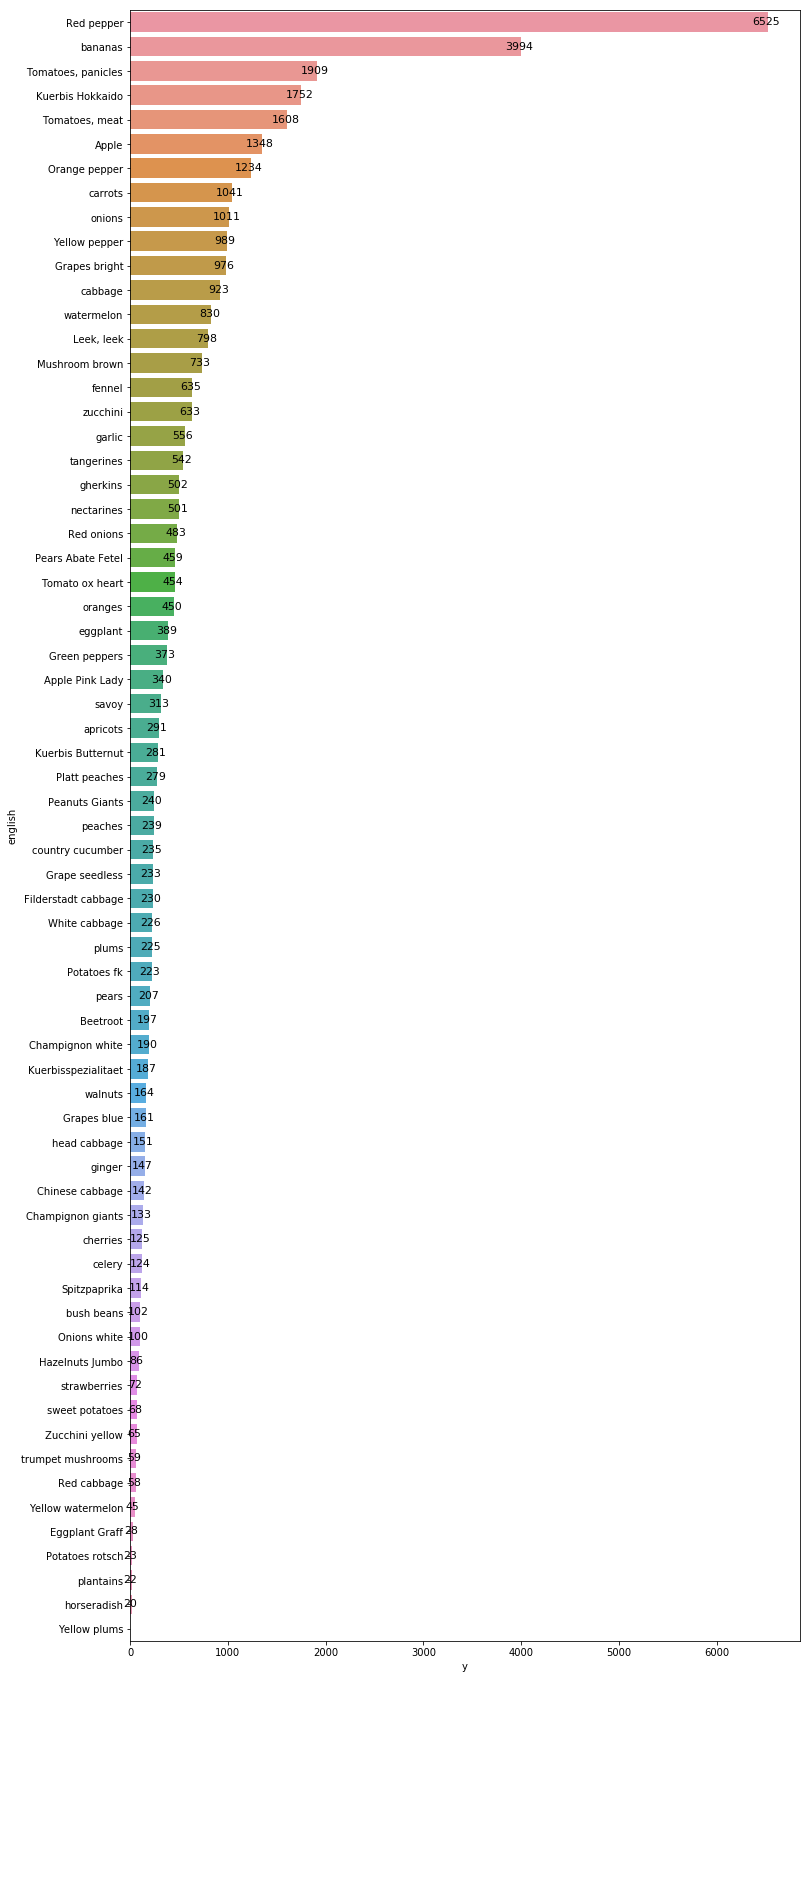

In [33]:
plt.figure(figsize=(12,30))

counts = df.groupby('english').agg('count').reset_index()[['english', 'y']]
counts.index = counts.english
counts = counts[['y']].sort_values(by='y', ascending=False)

ax = sns.barplot(counts.y,counts.index,orient='h')

for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width() - 20, p.get_y() + p.get_height()*1.5),
        ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
        textcoords='offset points')

plt.ion()
plt.show();


### Overrepresented categories

There are 2 dominant categories, red pepper and bananas with significant values of 6525 and 3994.  

This allows the trivial solution of predicting only the first 3 categories to reach to an average accuracy of 0.32 as shown below.

In [34]:
print ('Trivial accuracy')
(6525 + 3994 + 1909)/df.shape[0]

0.3288265643603651

### Underrepresented categories

Some classes are under-represented, like yellow plums which only appear twice.

This might have as consequence also poor predictive results for the underrepresented categories of products.

In [43]:
df[['english', 'y']].groupby('english').agg('count').sort_values(by='y').rename(columns={'y': 'count'})

count
english                   
Yellow plums             2
horseradish             20
plantains               22
Potatoes rotsch         23
Eggplant Graff          28
Yellow watermelon       45
Red cabbage             58
trumpet mushrooms       59
Zucchini yellow         65
sweet potatoes          68
strawberries            72
Hazelnuts Jumbo         86
Onions white           100
bush beans             102
Spitzpaprika           114
celery                 124
cherries               125
Champignon giants      133
Chinese cabbage        142
ginger                 147
head cabbage           151
Grapes blue            161
walnuts                164
Kuerbisspezialitaet    187
Champignon white       190
Beetroot               197
pears                  207
Potatoes fk            223
plums                  225
White cabbage          226
...                    ...
apricots               291
savoy                  313
Apple Pink Lady        340
Green peppers          373
eggplant               389
oranges                450
Tomato ox heart        454
Pears Abate Fetel      459
Red onions             483
nectarines             501
gherkins               502
tangerines             542
garlic                 556
zucchini               633
fennel                 635
Mushroom brown         733
Leek, leek             798
watermelon             830
cabbage                923
Grapes bright          976
Yellow pepper          989
onions                1011
carrots               1041
Orange pepper         1234
Apple                 1348
Tomatoes, meat        1608
Kuerbis Hokkaido      1752
Tomatoes, panicles    1909
bananas               3994
Red pepper            6525

[67 rows x 1 columns]

### Image visualisation

The method below renders the images given by their dataframe index in an annotated image grid.

In [107]:
def getMosaicForList(idx):
    imgshape = (480, 640, 3)
    mosaic = np.zeros((imgshape[0]*((len(idx))//5+1),imgshape[1]*5,3))
#     print(mosaic.shape)
    h = imgshape[0]
    w = imgshape[1]

    plt.figure(figsize=(18,18))
    ax = plt.subplot(111)

    for i in range(len(idx)):
        r = idx[i]
        img = misc.imread(df.path[r])
        x = i//5*h
        y = i%5*w
        mosaic[x:x+h,y:y+w] = img
        ax.annotate(df.english[r] + " " + str(df.index[r]), (y+240,x+400))

    plt.imshow(mosaic/255)
    plt.grid(False)

Images overview of a selection of products:

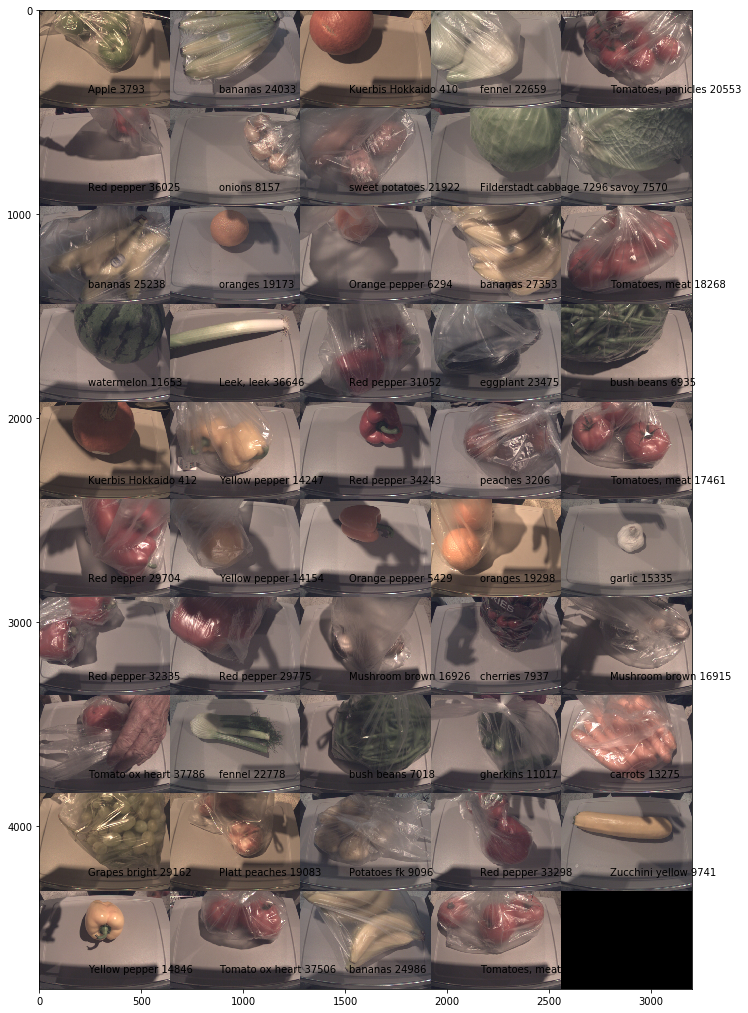

In [111]:
idx = []
for i in range(49):
    idx.append(random.randint(0,df.shape[0]-1))

getMosaicForList(idx)

## Image anomalies

### Shadows making contour recognition complicated

Hand shadows appear in multiple images and they will be part of what the NN learns:

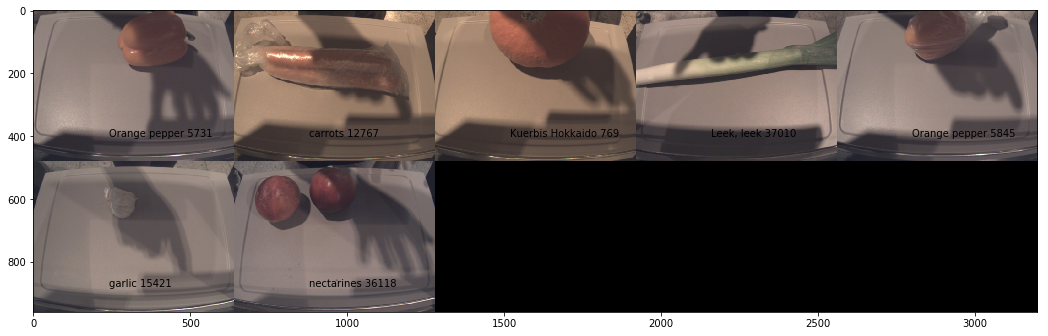

In [108]:
shadows = [ 5731, 12767, 769, 37010, 5845, 15421,36118 ]
getMosaicForList(shadows)

### Hands making contour recognition complicated

Human hands appear in multiple images and sometimes hide the products:

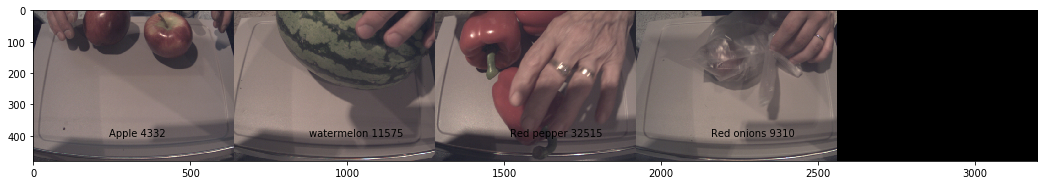

In [109]:
hands = [4332, 11575, 32515, 9310]
getMosaicForList(hands)

### Empty pictures making contour recognition complicated

Another defective category is the images with no visible product:

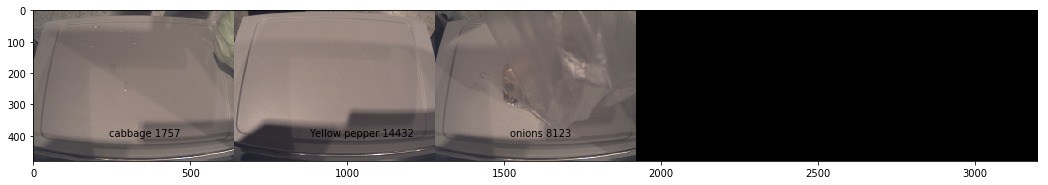

In [112]:
empty = [1757, 14432, 8123]
getMosaicForList(empty)

### Bananas making contour recognition complicated

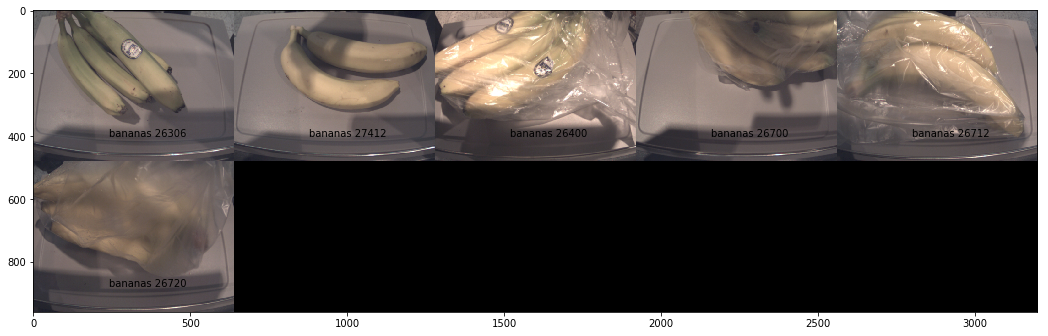

In [117]:
bananas = [ 26306, 27412, 26400, 26700,26712,26720]
getMosaicForList(bananas)

### Bananas/plantains categories are very similar and very difficult to distinguis even for humans

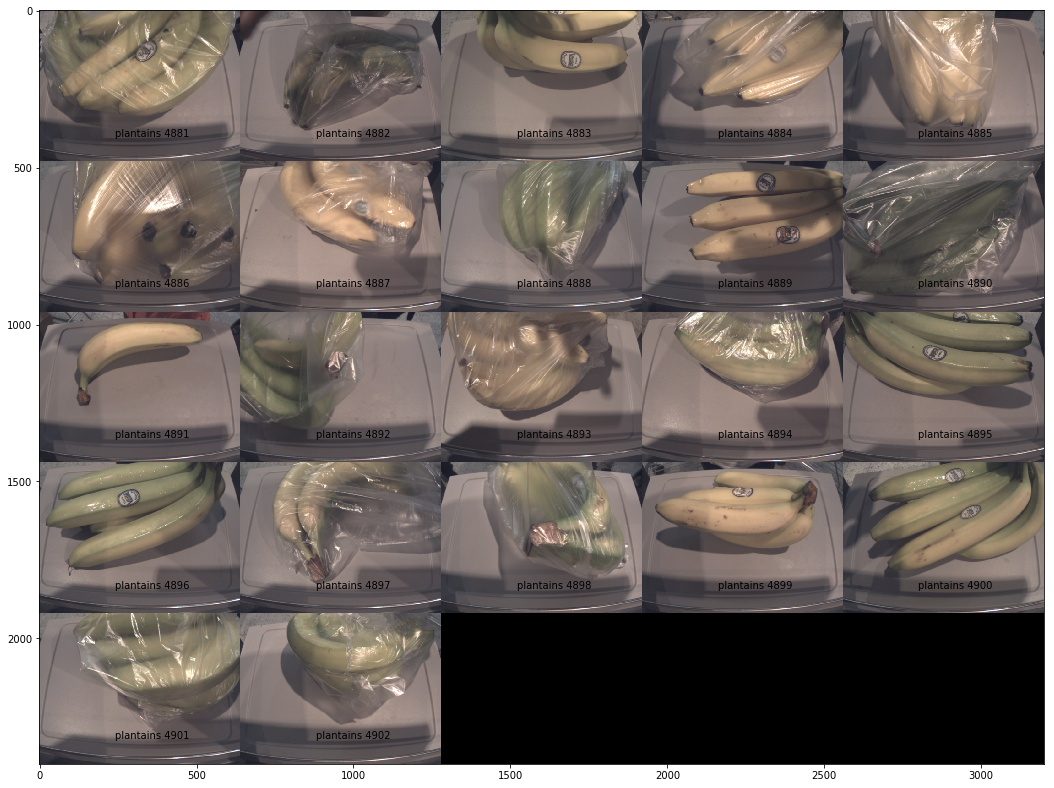

In [116]:
bananas = list(4881+np.arange(22))
getMosaicForList(bananas)

###  Apple/ Apple Pink Lady are very close categories and very difficult to tell apart even for humans

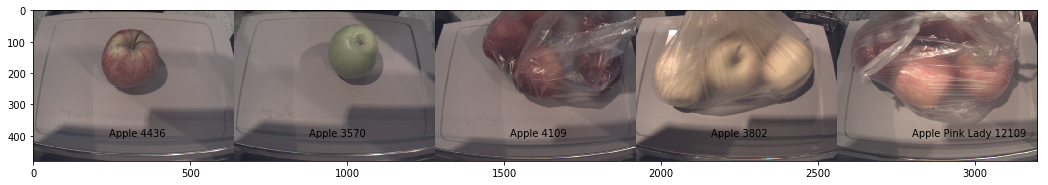

In [100]:
apple = [ 4436, 3570,  4109, 3802, 12109]
getMosaicForList(apple)

### Categories Orange Pepper/Red pepper are very difficult to distinguish

There are also mixed products like in the last photos shown below ( orange + red peppers in the same bag).

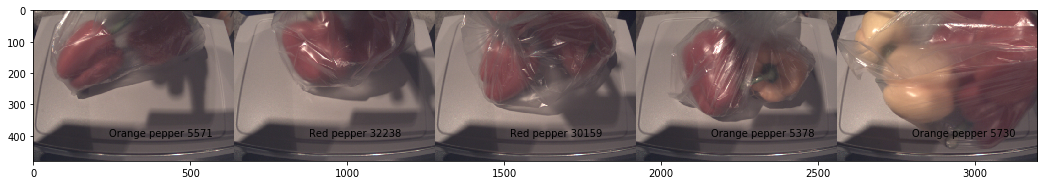

In [101]:
peppers = [5571, 32238, 30159, 5378, 5730]
getMosaicForList(peppers)

### Tomatoes panicles and tomatoes meat categories are very close and difficult to differentiate

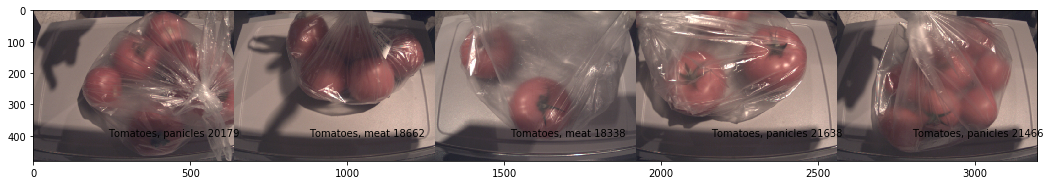

In [102]:
tomatoes = [20179, 18662, 18338, 21638, 21466]
getMosaicForList(tomatoes)

### Helper functions

Find below a few helper functions which will be called later on to normalize the image pixel content and to perform grayscale transformations.

In [44]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
        arr = arr - arr.mean()
        arr = arr/arr.std()
    return arr


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def grayscale(img):
    if len(img.shape) > 2 and img.shape[2] >= 3:
        img = rgb2gray(img)
    return img

## 3.4 Image edge detection and background removal

Let's start by choosing randomly one image from the dataset.

The following api calls assume the image is a 2-dimensional array so for achieving this purpose we use the grayscale utility function:

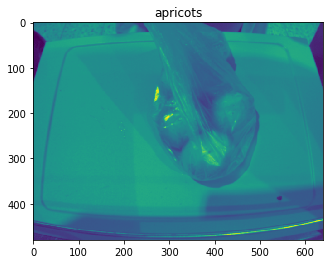

In [53]:
random_id= random.randint(0, df.shape[0])
img = misc.imread(df.iloc[random_id].path)
plt.title(df.iloc[random_id].english)
img = grayscale(img)
plt.imshow(img)


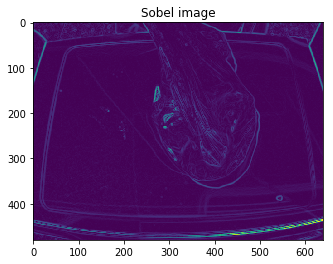

In [56]:
sobel = filters.sobel(img)

plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
# plt.rcParams['figure.dpi'] = 80

plt.title('Sobel image')
plt.imshow(sobel)
plt.show();


As the edges are not very clear, we try to apply a blur gaussian filter:

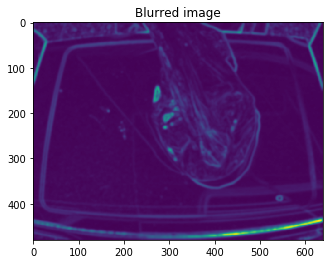

In [58]:
blurred = filters.gaussian(sobel, sigma=2.0)
plt.title('Blurred image')
plt.imshow(blurred);

Unfortunatelly this creates an image where the edges of the plastic bag are overemphasised.

This leads to the loss of product specificity image content.

The following attempt is for background removal using image segmentation:

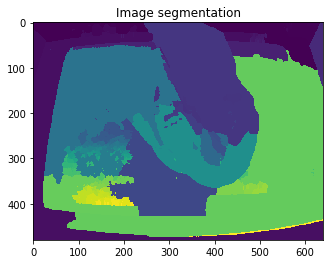

In [62]:
light_spots = np.array((img > 150).nonzero()).T
dark_spots = np.array((img < 40).nonzero()).T

bool_mask = np.zeros(img.shape, dtype=np.bool)
bool_mask[tuple(light_spots.T)] = True
bool_mask[tuple(dark_spots.T)] = True
seed_mask, num_seeds = ndi.label(bool_mask)

ws = morphology.watershed(blurred, seed_mask)
plt.title('Image segmentation')
plt.imshow(ws);


Unfortunatelly this technique also fails to correctly detect the image components' boundaries.

## 3.5 Image dataset augmentation

Due to the temporal constraints of the datathon we only chose one image augmentation technique: vertically flipped images.

This has the secondary advantage of conservating the reference points of the background trail as the camera is always placed at the same relative position.

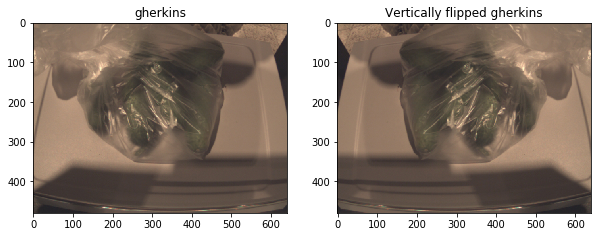

In [72]:
random_id= random.randint(0, df.shape[0])
img = misc.imread(df.iloc[random_id].path)
plt.figure(figsize=(10, 14))
plt.subplot(121)
plt.title(df.iloc[random_id].english)
plt.imshow(img)

plt.subplot(122)
plt.title('Vertically flipped ' + df.iloc[random_id].english)
plt.imshow(np.flip(img, axis = 1));

# 4. Modeling

This section details all predictive machine learning models we investigated together with all subsequent steps and helper function.   

We used transfer learning from multiple pretrained networks and this article also provides a comparative analysis of their performance, results and limitations.

## 4.1 Train/Test split 

We are using the pandas dataframe sample function in order to shuffle the data and provide a 80% / 20% split between train and validation sets.

In [78]:
train = df.sample(frac = 0.8)
test = df[~df.index.isin(train.index)]

print('Entire dataframe %s , train %s , validation set %s' % (df.shape, train.shape, test.shape))


Entire dataframe (37795, 5) , train (30236, 5) , validation set (7559, 5)


### Class weights

In order to reduce the bias of over/underrepresented classes, we pass to our training models a set of weights which convey the underlying distribution patterns

In [79]:
weights = 1/df.groupby('y').agg('count').reset_index()['cat'].values
weights

array([  4.54545455e-02,   5.70776256e-04,   3.58422939e-03,
         9.89119683e-04,   1.38888889e-02,   1.01112235e-03,
         3.43642612e-03,   8.00000000e-03,   1.99600798e-03,
         4.18410042e-03,   8.10372771e-04,   1.53256705e-04,
         4.34782609e-02,   2.22222222e-03,   1.47058824e-02,
         9.60614793e-04,   2.20264317e-03,   1.53846154e-02,
         6.80272109e-03,   2.50375563e-04,   5.00000000e-01,
         7.41839763e-04,   4.83091787e-03,   4.48430493e-03,
         5.34759358e-03,   6.21890547e-04,   5.23834468e-04,
         3.55871886e-03,   1.84501845e-03,   2.94117647e-03,
         2.17864924e-03,   8.77192982e-03,   6.21118012e-03,
         4.29184549e-03,   2.68096515e-03,   8.00000000e-03,
         1.00000000e-02,   1.16279070e-02,   4.25531915e-03,
         7.04225352e-03,   5.07614213e-03,   1.08342362e-03,
         6.62251656e-03,   1.20481928e-03,   1.57480315e-03,
         1.72413793e-02,   4.42477876e-03,   3.19488818e-03,
         7.51879699e-03,

The plot below illustrates the inverse dependency relationship between the frequency of representation of a class and its weight:

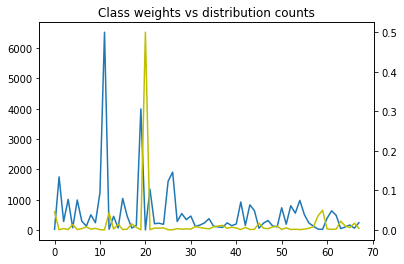

In [82]:
plt.plot(np.arange(len(weights)),df.groupby('y').agg('count').reset_index()['cat'].values)
plt.title('Class weights vs distribution counts')
ax2 = plt.twinx()
ax2 = plt.plot(np.arange(len(weights)),weights, color='y');


## 4.2 Keras callback

Find below the recurrent keras callback class which will provide a training real-time feedback for the evolution of the loss function/ accuracy metrics

In [84]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.acc = []
        self.cacc = []
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        ;

    def on_batch_end(self, epoch, logs={}):
        self.i = self.i +1
        
         
        if self.i%10 != 0:
            return
        
        curloss = logs.get('loss')
        self.cacc.append(logs.get('categorical_accuracy'))
        self.acc.append(logs.get('accuracy'))
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)

        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        fig = plt.figure()
        ax = plt.subplot(111)
        self.plotLosses(ax)
        plt.show()

    def plotLosses(self, ax):
        ax.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        ax.plot(np.arange(len(self.val_losses)), self.val_losses, label="val loss")
        plt.legend()
        ax2 = ax.twinx()
        ax2.plot(np.arange(len(self.acc)), self.acc, label="acc", c='r')
        ax2.plot(np.arange(len(self.cacc)), self.cacc, label="categorical_acc", c='r')
        # ax.set_yscale("log", nonposy='clip')
        plt.legend(['train', 'val', 'acc', 'categorical acc'])
        
basicLossPlot = PlotLosses();

### Utility functions for training

In [87]:
def generate_arrays_from_paths(df):
    while 1:
        for i in range(df.shape[0]):
            idx = df.index[i]
            img = normalize(images[idx])
            y = np.zeros((1,68))
            y[0,df.iloc[i].y]=1
            yield (img[newaxis,:,:,:], y)



def generate_arrays_from_paths_train(df):
    while 1:
        for i in range(df.shape[0]):
            idx = df.index[i]
            img = normalize(images[idx])
            img_flipped = np.flip(img, axis = 1)
            y = np.zeros((2,68))
            y[[0, 1],df.iloc[i].y]=1

            yield (np.stack([img, img_flipped]), y)
            
            
def generate_arrays_from_paths_train_batch(df, batch_size):
    if batch_size==1:
        print('doesn''t work, call other function for batch_size == 1')
        return generate_arrays_from_paths_train(df)
    else:
        while 1:
            for i in range(0, df.shape[0], batch_size):
                idx = df.index[i:i+batch_size]
                img = normalize(images[idx])
                img_flipped = np.flip(img, axis = 2)
                y = np.zeros((2*batch_size,68))
                y[np.arange(batch_size),df.loc[idx].y]=1
                y[batch_size+np.arange(batch_size),df.loc[idx].y]=1

                yield (np.concatenate([img, img_flipped]), y)         
                
                
def pc_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1),
                  K.argmax(y_pred, axis=-1)))
            

## 4.3 ML Models

The models below are presented in the ascending order of the best results provided:

### 1.  InceptionV3 Model

We started with InceptionV3 and we attempted to use it without training the lower layers. 

We added a relu and a softmax layer and used categorical crossentropy as loss function.


In [118]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(68, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 480, 640, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 239, 319, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 239, 319, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 239, 319, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## 2. Resnet softmax 

We retrained all ResNet50 layers except for the first 5. We added 2 dense layers with relu activation, a dropout and a final softmax. 

We minimize categorical crossentropy loss function and we evaluate categorical accuracy.

72% accuracy

In [ ]:
base_model =ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in base_model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(68, activation="softmax")(x)

# creating the final model 
model = Model(input = base_model.input, output = predictions)

# compile the model 
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model.summary()

## 3. Resnet sigmoid probabilities

We retrained all ResNet50 layers except for the first 5. We added 2 dense layers with relu activation, a dropout and a final sigmoid. 

We minimize categorical crossentropy loss function and we evaluate categorical accuracy.

In [ ]:
base_model =ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in base_model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(68, activation="sigmoid")(x)

# creating the final model 
model = Model(input = base_model.input, output = predictions)

# compile the model 
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model.summary()

## 4. VGG19 with final layer - softmax

We retrained all VGG19 layers except for the first 5. We added 2 dense layers with relu activation, a dropout and a final softmax. 

We minimize categorical crossentropy loss function and we evaluate categorical accuracy.

In [119]:
base_model =VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in base_model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(68, activation="softmax")(x)

# creating the final model 
model = Model(input = base_model.input, output = predictions)

# compile the model 
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy","categorical_accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0         
__________

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## 5. VGG19 with final layer - sigmoid

We retrained all VGG19 layers except for the first 5. We added 2 dense layers with relu activation, a dropout and a final sigmoid. 

We minimize categorical crossentropy loss function and we evaluate categorical accuracy.

In [123]:
base_model =VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in base_model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(68, activation="sigmoid")(x)
# creating the final model 
model = Model(input = base_model.input, output = predictions)

# compile the model 
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy','categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0         
__________

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## 6. VGG19 with final layer - sigmoid + softmax

We retrained all VGG19 layers except for the first 5. We added 2 dense layers with relu activation, a dropout and a final softmax. 

We minimize categorical crossentropy loss function and we evaluate categorical accuracy.

In [125]:
base_model =VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in base_model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(68, activation="sigmoid")(x)
trainprediction = Activation('softmax')(predictions)
# creating the final model 
modelPred = Model(input = base_model.input, output = predictions)
model = Model(input = base_model.input, output = trainprediction)

# compile the model 
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy','categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0         
__________

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


# Training phase

Find below the function we invoked repeatedly for all the models presented above.

basicLossPlot allows for realtime rendering of the accuracy and loss function

We are also passing the category representation weights and we execute the training on a batch of 5 elements at a time.


In [ ]:
basicLossPlot = PlotLosses()

In [ ]:
model.fit_generator(generate_arrays_from_paths_train_batch(train, 5),
                    class_weight=weights,
                    steps_per_epoch=train.shape[0]/5, epochs=1, callbacks=[basicLossPlot])



Model saving for comparaison and futute reference.

In [ ]:
# model.save('data/model77-14_00.h5')  
# model.save('data/res-net-softmax.h5')  
# model.save('data/vgg19-sigmoid-0.81.h5')  

# 5. Evaluation

## Assessment of predictive results

Find below the code we repeatedly used to assess all the above models:

In [ ]:
test = test.sample(frac = 1)
nb = test.shape[0]
pred = model.predict_generator(generate_arrays_from_paths(test), steps = nb)
print(classification_report(test.y[:nb], np.argmax(pred, axis = 1)))
print ('accuracy', accuracy_score(test.y[:nb], np.argmax(pred, axis = 1)))

plt.hist(np.argmax(pred, axis = 1), bins = 68)

In [ ]:
cm = np.stack(confusion_matrix(test.y[:nb], np.argmax(pred, axis = 1)))
ncm = np.divide(cm, cm.sum(axis=1))
plt.figure(figsize=(12, 12))
plt.xlabel('prediction')
plt.ylabel('truth')
sns.heatmap(cm, cmap = 'Blues')

In [ ]:
list(zip(*np.where(ncm > .3)))

In [ ]:
index = 4
c1 = 40
c2 = 38
plt.title(df[df.y == c1].cat.values[0])
plt.imshow(misc.imread(df[df.y == c1].path.values[index]))

plt.figure()
index = 0
plt.title(df[df.y == c2].cat.values[0])
plt.imshow(misc.imread(df[df.y == c2].path.values[index]))

<img src = 'img/probrank0cm.png'>

<img src = 'img/probrank1cm.png'>

<img src = 'img/probrank2cm.png'>

In [133]:
!ls img

accuracy.png			 probrank0cm.png  probrank2cm.png
normalizedconfusionmatrices.png  probrank1cm.png


<img src ='img/normalizedconfusionmatrices.png'>

<img src = 'img/accuracy.png'>

## Comparative analysis of results

<table> 
<tr>
<td>Model </td>
<td>Accuracy </td>
</tr>

<tr>
<td> Inception V3</td>
<td> </td>
</tr>

<tr>
<td> ResNet50 softmax </td>
<td> 72%</td>
</tr>


<tr>
<td> ResNet50 sigmoid </td>
<td> </td>
</tr>


<tr>
<td> VGG19 softmax</td>
<td> </td>
</tr>

<tr>
<td> VGG19 sigmoid</td>
<td> </td>
</tr>


<tr>
<td> VGG19 sigmoid + softmax</td>
<td> </td>
</tr>

</table>